Using device: cuda

Network architecture:
 BiharmonicPINN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=84, bias=True)
    (1-3): 3 x Linear(in_features=84, out_features=84, bias=True)
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
  (activation): Tanh()
)

Total trainable parameters: 21757

Computing f(x) = Δ²u_exact and (g1, g2) via autograd ...

Hyperparameters:
  N_INT              = 4000
  N_BD_PER_EDGE      = 400 (Nb = 1600)
  LAMBDA_INT         = 1.0
  LAMBDA_BC          = 10.0
  MAX_EPOCHS         = 30000
  TARGET_LOSS        = 1e-05
  LOG_EVERY          = 500
  INIT_LR            = 0.001
  STEP_SIZE_LR       = 5000
  GAMMA_LR           = 0.5
  LAYERS             = [2, 84, 84, 84, 84, 1]
  GRID_N             = 101

====================== Training PINN for P4 (Example 2) ======================

Epoch      1 | LR: 1.000e-03 | Total: 8.895e+00 | Int: 5.410e+00 | BC: 3.486e-01
Epoch    500 | LR: 1.000e-03 | Total: 2.344e-01 | Int: 1.978e-01 | 

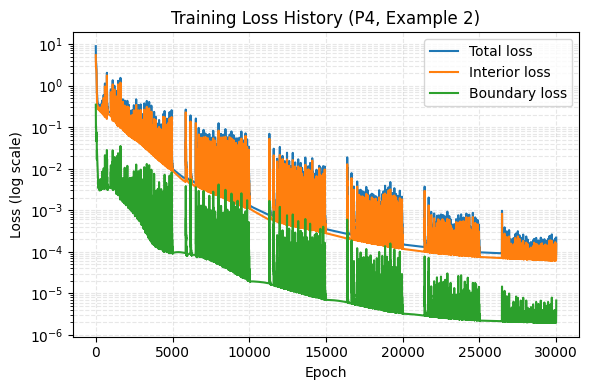

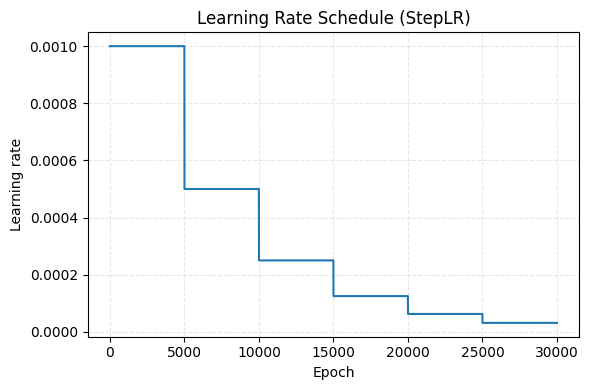

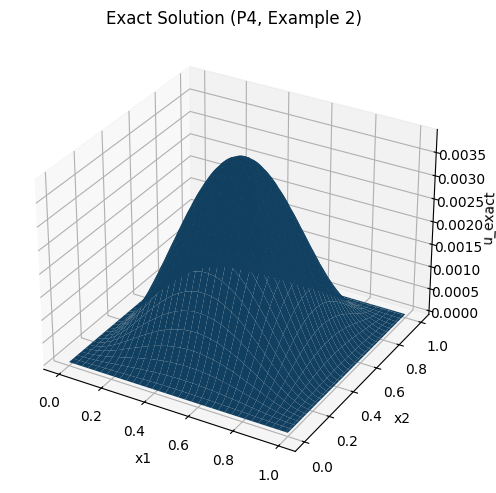

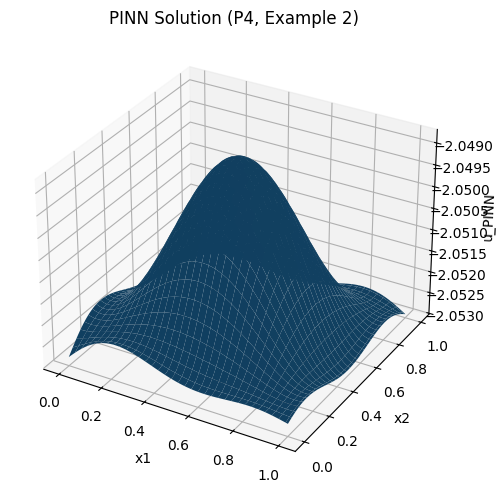

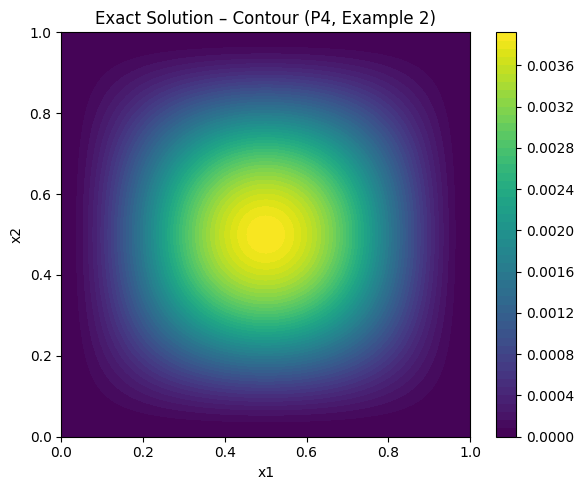

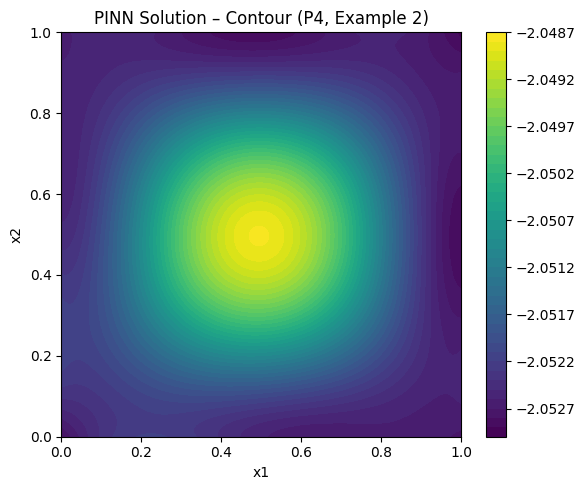


All plots saved in directory: p4_example2_results
Total training time (seconds): 2907.8707411289215
Network layers: [2, 84, 84, 84, 84, 1]
Done.


In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

# =============================================================================
# HYPERPARAMETERS (EDIT THESE LINES)
# =============================================================================
OUT_DIR        = "p4_example2_results"  # output directory for plots
SEED           = 42                     # random seed
TORCH_DTYPE    = torch.float64          # default dtype

N_INT          = 4000                   # interior collocation points Ni
N_BD_PER_EDGE  = 400                    # boundary points per edge (Nb = 4 * N_BD_PER_EDGE)

LAMBDA_INT     = 1.0                    # weight for interior (PDE) loss
LAMBDA_BC      = 10.0                   # weight for boundary loss

MAX_EPOCHS     = 30000                  # maximum training epochs
TARGET_LOSS    = 1e-5                   # stop if total loss <= TARGET_LOSS
LOG_EVERY      = 500                    # logging interval (epochs)

INIT_LR        = 1e-3                   # initial learning rate
STEP_SIZE_LR   = 5000                   # StepLR: step_size
GAMMA_LR       = 0.5                    # StepLR: gamma (multiplicative decay)

LAYERS         = [2, 84, 84, 84, 84, 1] # PINN architecture

GRID_N         = 101                    # evaluation grid size (GRID_N x GRID_N)
# =============================================================================
# END HYPERPARAMETERS
# =============================================================================

# =============================================================================
# Global setup
# =============================================================================
torch.set_default_dtype(TORCH_DTYPE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(SEED)
np.random.seed(SEED)

os.makedirs(OUT_DIR, exist_ok=True)

# =============================================================================
# Exact solution for Example 3.2 (P4):
#   u(x1, x2) = x1^2 x2^2 (1 - x1)^2 (1 - x2)^2
#   f  = Δ²u
#   g1 = ∂u/∂n
#   g2 = ∂Δu/∂n
#   Ω  = (0,1)^2
# =============================================================================

def u_exact(X):
    """
    Exact solution u(x1,x2) = x1^2 x2^2 (1-x1)^2 (1-x2)^2
    X: (N,2) tensor with columns (x1,x2)
    """
    x1 = X[:, 0:1]
    x2 = X[:, 1:2]
    return (x1**2) * (x2**2) * ((1.0 - x1)**2) * ((1.0 - x2)**2)

# =============================================================================
# PINN architecture
# =============================================================================

class BiharmonicPINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            lin = nn.Linear(layers[i], layers[i + 1])
            nn.init.xavier_uniform_(lin.weight)
            nn.init.zeros_(lin.bias)
            self.layers.append(lin)
        self.activation = nn.Tanh()

    def forward(self, x):
        for i, lin in enumerate(self.layers):
            x = lin(x)
            if i != len(self.layers) - 1:
                x = self.activation(x)
        return x


def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# =============================================================================
# Autograd helpers
# =============================================================================

def compute_grad_and_hessian(u, X):
    """
    Given u(X) with shape (N,1) and X (N,2, requires_grad=True),
    return:
      grad_u: (N,2) = (u_x, u_y)
      (u_xx, u_yy, u_xy_sym): each (N,1)
    """
    grad_u = torch.autograd.grad(
        u, X,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]  # (N,2)

    u_x = grad_u[:, 0:1]
    u_y = grad_u[:, 1:2]

    grad_u_x = torch.autograd.grad(
        u_x, X,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True
    )[0]
    grad_u_y = torch.autograd.grad(
        u_y, X,
        grad_outputs=torch.ones_like(u_y),
        create_graph=True
    )[0]

    u_xx = grad_u_x[:, 0:1]
    u_xy = grad_u_x[:, 1:2]
    u_yx = grad_u_y[:, 0:1]
    u_yy = grad_u_y[:, 1:2]

    u_xy_sym = 0.5 * (u_xy + u_yx)
    return grad_u, (u_xx, u_yy, u_xy_sym)


def biharmonic_u(u, X):
    """
    Compute Δ²u via autograd using:
        Δ²u = Δ(Δu)
    """
    grad_u, (u_xx, u_yy, u_xy) = compute_grad_and_hessian(u, X)
    lap_u = u_xx + u_yy              # Δu
    grad_lap, (lap_xx, lap_yy, lap_xy) = compute_grad_and_hessian(lap_u, X)
    return lap_xx + lap_yy           # Δ(Δu) = Δ²u


def normal_derivative(u, X, normals):
    """
    ∂u/∂n = n · ∇u
    """
    grad_u, _ = compute_grad_and_hessian(u, X)
    return torch.sum(grad_u * normals, dim=1, keepdim=True)


def normal_derivative_laplacian(u, X, normals):
    """
    ∂Δu/∂n = n · ∇(Δu)
    """
    grad_u, (u_xx, u_yy, u_xy) = compute_grad_and_hessian(u, X)
    lap_u = u_xx + u_yy
    grad_lap, _ = compute_grad_and_hessian(lap_u, X)
    return torch.sum(grad_lap * normals, dim=1, keepdim=True)

# =============================================================================
# Collocation point sampling
# =============================================================================

def sample_interior(N_int):
    """
    Interior collocation points {x_j} ⊂ Ω = (0,1)^2.
    """
    X_int = torch.rand(N_int, 2, device=device)
    X_int.requires_grad_(True)
    return X_int


def sample_boundary(N_bd_per_edge):
    """
    Boundary collocation points {y_k} ⊂ ∂Ω with outward unit normals.
    """
    y = torch.rand(N_bd_per_edge, 1, device=device)
    x = torch.rand(N_bd_per_edge, 1, device=device)

    # Left: x1 = 0, n = (-1,0)
    left = torch.cat([torch.zeros_like(y), y], dim=1)
    n_left = torch.cat([-torch.ones_like(y), torch.zeros_like(y)], dim=1)

    # Right: x1 = 1, n = (1,0)
    right = torch.cat([torch.ones_like(y), y], dim=1)
    n_right = torch.cat([torch.ones_like(y), torch.zeros_like(y)], dim=1)

    # Bottom: x2 = 0, n = (0,-1)
    bottom = torch.cat([x, torch.zeros_like(x)], dim=1)
    n_bottom = torch.cat([torch.zeros_like(x), -torch.ones_like(x)], dim=1)

    # Top: x2 = 1, n = (0,1)
    top = torch.cat([x, torch.ones_like(x)], dim=1)
    n_top = torch.cat([torch.zeros_like(x), torch.ones_like(x)], dim=1)

    X_bd = torch.cat([left, right, bottom, top], dim=0)
    normals = torch.cat([n_left, n_right, n_bottom, n_top], dim=0)

    X_bd.requires_grad_(True)
    return X_bd, normals

# =============================================================================
# Exact f, g1, g2 using autograd:
#   f  = Δ²u
#   g1 = ∂u/∂n
#   g2 = ∂Δu/∂n
# =============================================================================

def f_source_autograd(X_in):
    """
    f(x) = Δ² u_exact(x) via autograd.
    """
    X = X_in.clone().detach().to(device)
    X.requires_grad_(True)
    u_ex = u_exact(X)
    bih_ex = biharmonic_u(u_ex, X)
    return bih_ex.detach()


def boundary_data_autograd(X_bd_in, normals_bd):
    """
    Compute g1 = ∂u/∂n, g2 = ∂Δu/∂n on ∂Ω using autograd.
    """
    X_bd = X_bd_in.clone().detach().to(device)
    X_bd.requires_grad_(True)
    u_bd_ex = u_exact(X_bd)
    g1 = normal_derivative(u_bd_ex, X_bd, normals_bd)
    g2 = normal_derivative_laplacian(u_bd_ex, X_bd, normals_bd)
    return g1.detach(), g2.detach()


def exact_quantities_autograd(X_in):
    """
    For error computation: compute
      u, ∇u, Hessian(u) for u_exact via autograd (detached).
    """
    X = X_in.clone().detach().to(device)
    X.requires_grad_(True)
    u_ex = u_exact(X)
    grad_ex, (uxx_ex, uyy_ex, uxy_ex) = compute_grad_and_hessian(u_ex, X)
    return (u_ex.detach(),
            grad_ex.detach(),
            uxx_ex.detach(),
            uyy_ex.detach(),
            uxy_ex.detach())

# =============================================================================
# Create network, collocation points, and exact PDE/BC data
# =============================================================================

net = BiharmonicPINN(LAYERS).to(device)
print("\nNetwork architecture:\n", net)
print("\nTotal trainable parameters:", count_parameters(net))

X_int = sample_interior(N_INT)
X_bd, normals_bd = sample_boundary(N_BD_PER_EDGE)

print("\nComputing f(x) = Δ²u_exact and (g1, g2) via autograd ...")
f_int = f_source_autograd(X_int)
g1_bd, g2_bd = boundary_data_autograd(X_bd, normals_bd)

print("\nHyperparameters:")
print(f"  N_INT              = {N_INT}")
print(f"  N_BD_PER_EDGE      = {N_BD_PER_EDGE} (Nb = {4*N_BD_PER_EDGE})")
print(f"  LAMBDA_INT         = {LAMBDA_INT}")
print(f"  LAMBDA_BC          = {LAMBDA_BC}")
print(f"  MAX_EPOCHS         = {MAX_EPOCHS}")
print(f"  TARGET_LOSS        = {TARGET_LOSS}")
print(f"  LOG_EVERY          = {LOG_EVERY}")
print(f"  INIT_LR            = {INIT_LR}")
print(f"  STEP_SIZE_LR       = {STEP_SIZE_LR}")
print(f"  GAMMA_LR           = {GAMMA_LR}")
print(f"  LAYERS             = {LAYERS}")
print(f"  GRID_N             = {GRID_N}")

optimizer = torch.optim.Adam(net.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=STEP_SIZE_LR, gamma=GAMMA_LR
)

loss_history_total = []
loss_history_int = []
loss_history_bc = []
lr_history = []

# =============================================================================
# Training loop: P4 (Cahn–Hilliard BC)
#   Δ²u = f in Ω
#   ∂u/∂n = g1 on ∂Ω
#   ∂Δu/∂n = g2 on ∂Ω
# =============================================================================

start_time = time.time()
print("\n====================== Training PINN for P4 (Example 2) ======================\n")

for epoch in range(1, MAX_EPOCHS + 1):
    current_lr = optimizer.param_groups[0]["lr"]
    lr_history.append(current_lr)

    optimizer.zero_grad()

    # Interior loss: L_int = (1/Ni) Σ |Δ²uθ - f|²
    u_int = net(X_int)
    bih_int = biharmonic_u(u_int, X_int)
    res_int = bih_int - f_int
    L_int = torch.mean(res_int**2)

    # Boundary loss:
    # L_bc = (1/Nb) Σ [ |∂uθ/∂n - g1|² + |∂Δuθ/∂n - g2|² ]
    u_bd = net(X_bd)
    du_dn_pred = normal_derivative(u_bd, X_bd, normals_bd)
    dlap_dn_pred = normal_derivative_laplacian(u_bd, X_bd, normals_bd)

    L_bc_u = torch.mean((du_dn_pred - g1_bd)**2)
    L_bc_lap = torch.mean((dlap_dn_pred - g2_bd)**2)
    L_bc = L_bc_u + L_bc_lap

    loss = LAMBDA_INT * L_int + LAMBDA_BC * L_bc

    loss.backward()
    optimizer.step()
    scheduler.step()  # StepLR, no verbose

    loss_history_total.append(loss.item())
    loss_history_int.append(L_int.item())
    loss_history_bc.append(L_bc.item())

    if epoch == 1 or epoch % LOG_EVERY == 0:
        print(
            f"Epoch {epoch:6d} | "
            f"LR: {current_lr:.3e} | "
            f"Total: {loss.item():.3e} | "
            f"Int: {L_int.item():.3e} | "
            f"BC: {L_bc.item():.3e}"
        )

    if loss.item() <= TARGET_LOSS:
        print(f"\nTarget loss {TARGET_LOSS} reached at epoch {epoch}. Stopping training.")
        break

end_time = time.time()
training_time = end_time - start_time
print(f"\nTraining completed in {training_time:.2f} seconds.")

# =============================================================================
# Error computation on dense grid
#   L2 error          = ||u - uθ||_L2
#   Energy error      = ||u - uθ||_L2 + ||∇(u - uθ)||_L2
#   L2 relative       = L2_error / ||u||_L2
#   H1 relative       = Energy_error / (||u||_L2 + ||∇u||_L2)
#   (all approximated on a uniform grid in Ω with area 1)
# =============================================================================

print("\n====================== Evaluating on dense grid ======================\n")

xs = torch.linspace(0.0, 1.0, GRID_N, device=device)
ys = torch.linspace(0.0, 1.0, GRID_N, device=device)
Xg, Yg = torch.meshgrid(xs, ys, indexing="ij")
test_points = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=1)
test_points.requires_grad_(True)

# Predicted solution
u_pred = net(test_points)
grad_pred, (uxx_pred, uyy_pred, uxy_pred) = compute_grad_and_hessian(u_pred, test_points)

# Exact solution (via autograd)
u_ex, grad_ex, uxx_ex, uyy_ex, uxy_ex = exact_quantities_autograd(test_points)

# Differences
du = u_pred - u_ex
grad_diff = grad_pred - grad_ex

u_diff_sq = du**2
grad_diff_sq = grad_diff[:, 0:1]**2 + grad_diff[:, 1:2]**2

u_sq = u_ex**2
grad_sq = grad_ex[:, 0:1]**2 + grad_ex[:, 1:2]**2

# L2 norms ~ sqrt(mean(..)) since |Ω| = 1
L2_error = torch.sqrt(torch.mean(u_diff_sq)).item()
grad_L2_error = torch.sqrt(torch.mean(grad_diff_sq)).item()
L2_u = torch.sqrt(torch.mean(u_sq)).item()
L2_grad_u = torch.sqrt(torch.mean(grad_sq)).item()

energy_error = L2_error + grad_L2_error
L2_rel = L2_error / L2_u
H1_rel = energy_error / (L2_u + L2_grad_u)

# H2-like relative error (optional, not required by PDF but handy)
hess_diff_sq = (uxx_pred - uxx_ex)**2 + (uyy_pred - uyy_ex)**2 + 2.0 * (uxy_pred - uxy_ex)**2
hess_sq = uxx_ex**2 + uyy_ex**2 + 2.0 * (uxy_ex**2)
H2_rel_extra = torch.sqrt(
    torch.mean(u_diff_sq + grad_diff_sq + hess_diff_sq) /
    torch.mean(u_sq + grad_sq + hess_sq)
).item()

print(f"L2 error              ≈ {L2_error:.3e}")
print(f"Energy error (H1)     ≈ {energy_error:.3e}")
print(f"L2 relative error     ≈ {L2_rel:.3e}")
print(f"H1 relative error     ≈ {H1_rel:.3e}")
print(f"H2 relative (extra)   ≈ {H2_rel_extra:.3e}")

# =============================================================================
# Plots: loss, learning rate, 3D, 2D contours
# =============================================================================

epochs_range = np.arange(1, len(loss_history_total) + 1)

# 1) Loss history
plt.figure(figsize=(6, 4))
plt.semilogy(epochs_range, loss_history_total, label="Total loss")
plt.semilogy(epochs_range, loss_history_int,  label="Interior loss")
plt.semilogy(epochs_range, loss_history_bc,   label="Boundary loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Training Loss History (P4, Example 2)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "loss_history_p4_example2.png"), dpi=300)
plt.show()

# 2) Learning rate history
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, lr_history[:len(epochs_range)])
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Learning Rate Schedule (StepLR)")
plt.grid(True, ls="--", alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "lr_history_p4_example2.png"), dpi=300)
plt.show()

# Prepare 2D grids
U_exact_grid = u_ex.detach().cpu().numpy().reshape(GRID_N, GRID_N)
U_pred_grid = u_pred.detach().cpu().numpy().reshape(GRID_N, GRID_N)
X_plot = Xg.detach().cpu().numpy()
Y_plot = Yg.detach().cpu().numpy()

# 3a) Exact solution – 3D surface
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X_plot, Y_plot, U_exact_grid, linewidth=0, antialiased=True)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("u_exact")
ax.set_title("Exact Solution (P4, Example 2)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "exact_solution_3d_p4_example2.png"), dpi=300)
plt.show()

# 3b) PINN solution – 3D surface
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X_plot, Y_plot, U_pred_grid, linewidth=0, antialiased=True)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("u_PINN")
ax.set_title("PINN Solution (P4, Example 2)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pinn_solution_3d_p4_example2.png"), dpi=300)
plt.show()

# 4a) Exact solution – 2D contour
plt.figure(figsize=(6, 5))
cont1 = plt.contourf(X_plot, Y_plot, U_exact_grid, levels=50)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Exact Solution – Contour (P4, Example 2)")
plt.colorbar(cont1)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "exact_solution_contour_p4_example2.png"), dpi=300)
plt.show()

# 4b) PINN solution – 2D contour
plt.figure(figsize=(6, 5))
cont2 = plt.contourf(X_plot, Y_plot, U_pred_grid, levels=50)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("PINN Solution – Contour (P4, Example 2)")
plt.colorbar(cont2)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pinn_solution_contour_p4_example2.png"), dpi=300)
plt.show()

print("\nAll plots saved in directory:", OUT_DIR)
print("Total training time (seconds):", training_time)
print("Network layers:", LAYERS)
print("Done.")


Using device: cuda

Network:
 BiharmonicPINN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=96, bias=True)
    (1-3): 3 x Linear(in_features=96, out_features=96, bias=True)
    (4): Linear(in_features=96, out_features=1, bias=True)
  )
  (activation): Tanh()
)

Total parameters: 28321

====================== Adam training (P4, Example 3.2) ======================

Epoch      1 | LR: 1.000e-03 | Total: 8.904e+00 | Int: 5.661e+00 | BC: 3.243e-01
Epoch    500 | LR: 1.000e-03 | Total: 2.422e-01 | Int: 2.055e-01 | BC: 3.674e-03
Epoch   1000 | LR: 1.000e-03 | Total: 2.551e-01 | Int: 2.210e-01 | BC: 3.414e-03
Epoch   1500 | LR: 1.000e-03 | Total: 2.156e-01 | Int: 1.862e-01 | BC: 2.938e-03
Epoch   2000 | LR: 1.000e-03 | Total: 1.438e-01 | Int: 1.196e-01 | BC: 2.417e-03
Epoch   2500 | LR: 1.000e-03 | Total: 5.739e-02 | Int: 4.938e-02 | BC: 8.006e-04
Epoch   3000 | LR: 1.000e-03 | Total: 3.110e-02 | Int: 2.821e-02 | BC: 2.893e-04
Epoch   3500 | LR: 1.000e-03 | Total: 1.835e-

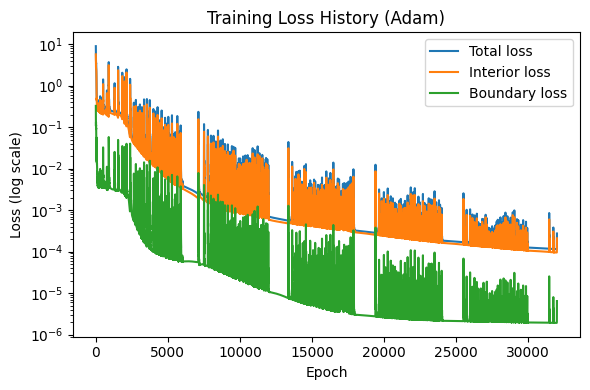

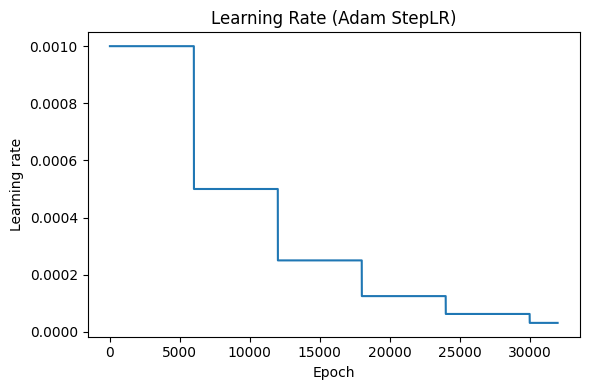

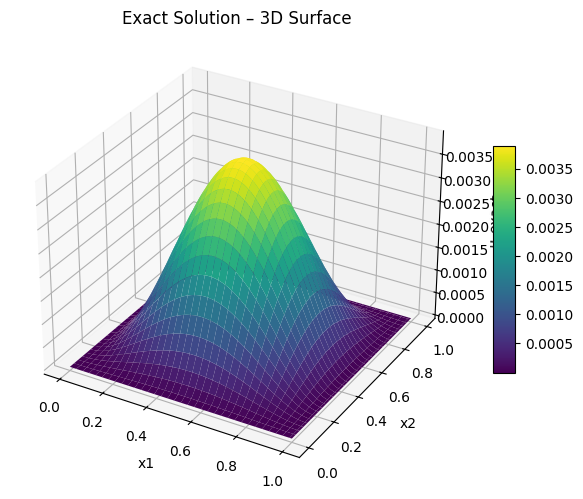

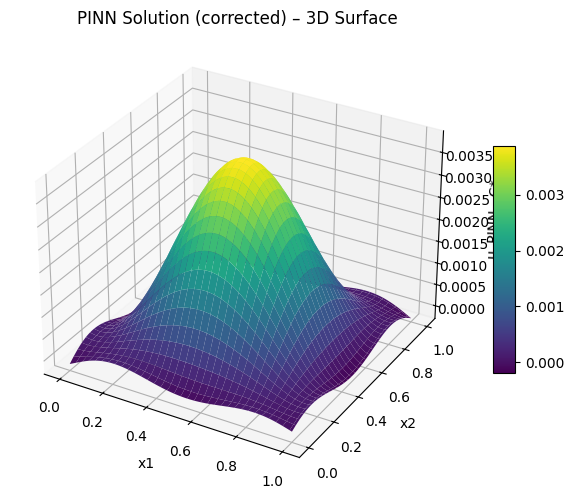

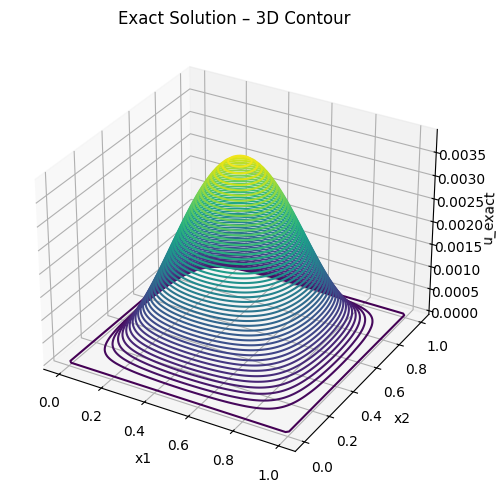

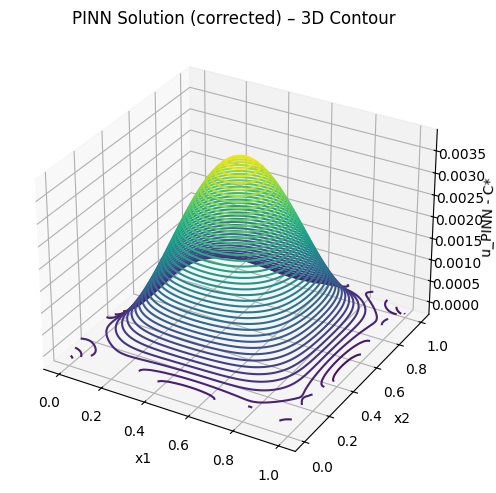

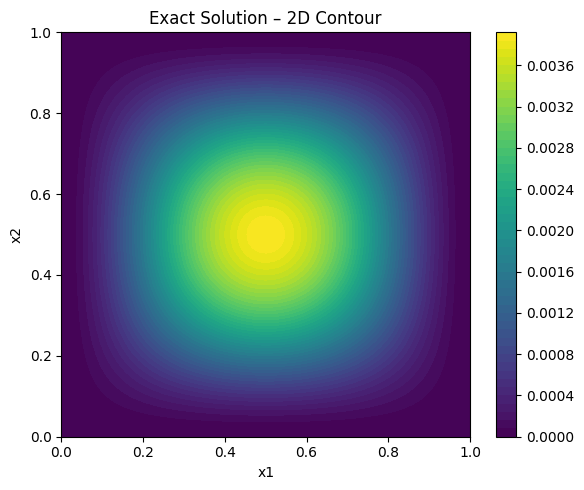

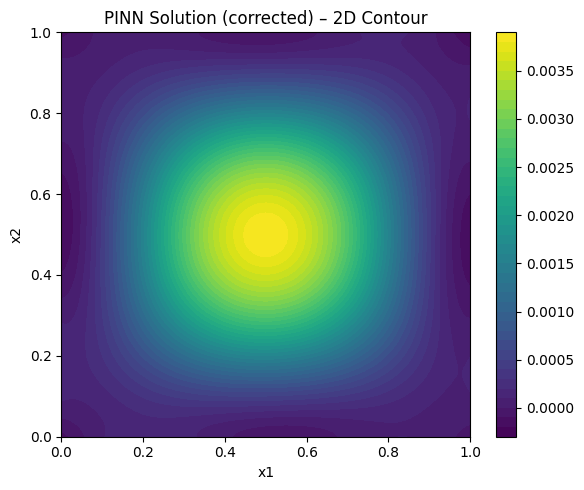


All results (plots + models) saved in: p4_example2_results_const_lbfgs_nors


In [4]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =============================================================================
# HYPERPARAMETERS (TUNE HERE)
# =============================================================================
OUT_DIR          = "p4_example2_results_const_lbfgs_nors"
SEED             = 42
TORCH_DTYPE      = torch.float64

# Collocation points
N_INT            = 6000          # interior points
N_BD_PER_EDGE    = 600           # boundary points per edge (Nb = 4*N_BD_PER_EDGE)

# Loss weights
LAMBDA_INT       = 1.0
LAMBDA_BC        = 10.0

# Adam stage
MAX_EPOCHS_ADAM  = 32000
TARGET_LOSS      = 1e-5          # stop if total loss <= TARGET_LOSS
LOG_EVERY        = 500

INIT_LR          = 1e-3
STEP_SIZE_LR     = 6000
GAMMA_LR         = 0.5

# LBFGS refinement
USE_LBFGS        = True
LBFGS_MAX_ITER   = 1500
LBFGS_LR         = 1.0

# Network & evaluation grid
LAYERS           = [2, 96, 96, 96, 96, 1]
GRID_N           = 101
# =============================================================================

torch.set_default_dtype(TORCH_DTYPE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(SEED)
np.random.seed(SEED)
os.makedirs(OUT_DIR, exist_ok=True)

# =============================================================================
# Exact solution (for data generation & evaluation ONLY)
#   u(x1, x2) = x1^2 x2^2 (1 - x1)^2 (1 - x2)^2
# =============================================================================
def u_exact(X):
    x1 = X[:, 0:1]
    x2 = X[:, 1:2]
    return (x1**2) * (x2**2) * ((1.0 - x1)**2) * ((1.0 - x2)**2)

# =============================================================================
# PINN architecture
# =============================================================================
class BiharmonicPINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            lin = nn.Linear(layers[i], layers[i + 1])
            nn.init.xavier_uniform_(lin.weight)
            nn.init.zeros_(lin.bias)
            self.layers.append(lin)
        self.activation = nn.Tanh()

    def forward(self, x):
        for i, lin in enumerate(self.layers):
            x = lin(x)
            if i != len(self.layers) - 1:
                x = self.activation(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# =============================================================================
# Autograd helpers
# =============================================================================
def compute_grad_and_hessian(u, X):
    grad_u = torch.autograd.grad(
        u, X,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]
    u_x = grad_u[:, 0:1]
    u_y = grad_u[:, 1:2]

    grad_u_x = torch.autograd.grad(
        u_x, X,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True
    )[0]
    grad_u_y = torch.autograd.grad(
        u_y, X,
        grad_outputs=torch.ones_like(u_y),
        create_graph=True
    )[0]

    u_xx = grad_u_x[:, 0:1]
    u_xy = grad_u_x[:, 1:2]
    u_yx = grad_u_y[:, 0:1]
    u_yy = grad_u_y[:, 1:2]
    u_xy_sym = 0.5 * (u_xy + u_yx)
    return grad_u, (u_xx, u_yy, u_xy_sym)

def biharmonic_u(u, X):
    grad_u, (u_xx, u_yy, u_xy) = compute_grad_and_hessian(u, X)
    lap_u = u_xx + u_yy
    grad_lap, (lap_xx, lap_yy, lap_xy) = compute_grad_and_hessian(lap_u, X)
    return lap_xx + lap_yy

def normal_derivative(u, X, normals):
    grad_u, _ = compute_grad_and_hessian(u, X)
    return torch.sum(grad_u * normals, dim=1, keepdim=True)

def normal_derivative_laplacian(u, X, normals):
    grad_u, (u_xx, u_yy, u_xy) = compute_grad_and_hessian(u, X)
    lap_u = u_xx + u_yy
    grad_lap, _ = compute_grad_and_hessian(lap_u, X)
    return torch.sum(grad_lap * normals, dim=1, keepdim=True)

# =============================================================================
# Collocation sampling
# =============================================================================
def sample_interior(N_int):
    X_int = torch.rand(N_int, 2, device=device)
    X_int.requires_grad_(True)
    return X_int

def sample_boundary(N_bd_per_edge):
    y = torch.rand(N_bd_per_edge, 1, device=device)
    x = torch.rand(N_bd_per_edge, 1, device=device)

    left   = torch.cat([torch.zeros_like(y), y], dim=1)
    n_left = torch.cat([-torch.ones_like(y), torch.zeros_like(y)], dim=1)

    right   = torch.cat([torch.ones_like(y), y], dim=1)
    n_right = torch.cat([torch.ones_like(y), torch.zeros_like(y)], dim=1)

    bottom   = torch.cat([x, torch.zeros_like(x)], dim=1)
    n_bottom = torch.cat([torch.zeros_like(x), -torch.ones_like(x)], dim=1)

    top   = torch.cat([x, torch.ones_like(x)], dim=1)
    n_top = torch.cat([torch.zeros_like(x), torch.ones_like(x)], dim=1)

    X_bd = torch.cat([left, right, bottom, top], dim=0)
    normals = torch.cat([n_left, n_right, n_bottom, n_top], dim=0)

    X_bd.requires_grad_(True)
    return X_bd, normals

# =============================================================================
# PDE & BC data generation
# =============================================================================
def f_source_autograd(X_in):
    X = X_in.clone().detach().to(device)
    X.requires_grad_(True)
    u_ex = u_exact(X)
    bih_ex = biharmonic_u(u_ex, X)
    return bih_ex.detach()

def boundary_data_autograd(X_bd_in, normals_bd):
    X_bd = X_bd_in.clone().detach().to(device)
    X_bd.requires_grad_(True)
    u_bd_ex = u_exact(X_bd)
    g1 = normal_derivative(u_bd_ex, X_bd, normals_bd)
    g2 = normal_derivative_laplacian(u_bd_ex, X_bd, normals_bd)
    return g1.detach(), g2.detach()

def exact_quantities_autograd(X_in):
    X = X_in.clone().detach().to(device)
    X.requires_grad_(True)
    u_ex = u_exact(X)
    grad_ex, (uxx_ex, uyy_ex, uxy_ex) = compute_grad_and_hessian(u_ex, X)
    return u_ex.detach(), grad_ex.detach(), uxx_ex.detach(), uyy_ex.detach(), uxy_ex.detach()

# =============================================================================
# Setup network & data
# =============================================================================
net = BiharmonicPINN(LAYERS).to(device)
print("\nNetwork:\n", net)
print("\nTotal parameters:", count_parameters(net))

X_int = sample_interior(N_INT)
X_bd, normals_bd = sample_boundary(N_BD_PER_EDGE)
f_int = f_source_autograd(X_int)
g1_bd, g2_bd = boundary_data_autograd(X_bd, normals_bd)

optimizer = torch.optim.Adam(net.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=STEP_SIZE_LR, gamma=GAMMA_LR
)

loss_history_total = []
loss_history_int   = []
loss_history_bc    = []
lr_history         = []

print("\n====================== Adam training (P4, Example 3.2) ======================\n")
start_time = time.time()

for epoch in range(1, MAX_EPOCHS_ADAM + 1):
    current_lr = optimizer.param_groups[0]["lr"]
    lr_history.append(current_lr)

    optimizer.zero_grad()

    # Interior loss
    u_int = net(X_int)
    bih_int = biharmonic_u(u_int, X_int)
    res_int = bih_int - f_int
    L_int = torch.mean(res_int**2)

    # Boundary loss
    u_bd = net(X_bd)
    du_dn_pred   = normal_derivative(u_bd, X_bd, normals_bd)
    dlap_dn_pred = normal_derivative_laplacian(u_bd, X_bd, normals_bd)

    L_bc_u   = torch.mean((du_dn_pred   - g1_bd)**2)
    L_bc_lap = torch.mean((dlap_dn_pred - g2_bd)**2)
    L_bc = L_bc_u + L_bc_lap

    loss = LAMBDA_INT * L_int + LAMBDA_BC * L_bc
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history_total.append(loss.item())
    loss_history_int.append(L_int.item())
    loss_history_bc.append(L_bc.item())

    if epoch == 1 or epoch % LOG_EVERY == 0:
        print(
            f"Epoch {epoch:6d} | "
            f"LR: {current_lr:.3e} | "
            f"Total: {loss.item():.3e} | "
            f"Int: {L_int.item():.3e} | "
            f"BC: {L_bc.item():.3e}"
        )

    if loss.item() <= TARGET_LOSS:
        print(f"\nTarget loss {TARGET_LOSS:.1e} reached at epoch {epoch}. Stopping Adam.")
        break

# =============================================================================
# LBFGS refinement
# =============================================================================
if USE_LBFGS:
    print("\n====================== LBFGS refinement ======================\n")
    lbfgs = torch.optim.LBFGS(
        net.parameters(),
        lr=LBFGS_LR,
        max_iter=LBFGS_MAX_ITER,
        history_size=100,
        line_search_fn="strong_wolfe"
    )

    def closure():
        lbfgs.zero_grad()
        u_int = net(X_int)
        bih_int = biharmonic_u(u_int, X_int)
        res_int = bih_int - f_int
        L_int = torch.mean(res_int**2)

        u_bd = net(X_bd)
        du_dn_pred   = normal_derivative(u_bd, X_bd, normals_bd)
        dlap_dn_pred = normal_derivative_laplacian(u_bd, X_bd, normals_bd)

        L_bc_u   = torch.mean((du_dn_pred   - g1_bd)**2)
        L_bc_lap = torch.mean((dlap_dn_pred - g2_bd)**2)
        L_bc = L_bc_u + L_bc_lap

        loss_lbfgs = LAMBDA_INT * L_int + LAMBDA_BC * L_bc
        loss_lbfgs.backward()
        return loss_lbfgs

    final_loss = lbfgs.step(closure)
    print(f"LBFGS final loss: {final_loss.item():.3e}")

end_time = time.time()
training_time = end_time - start_time
print(f"\nTotal training time (Adam + LBFGS): {training_time:.2f} seconds.")

# =============================================================================
# Save model
# =============================================================================
state_path = os.path.join(OUT_DIR, "p4_example2_pinn_state_dict.pth")
full_path  = os.path.join(OUT_DIR, "p4_example2_pinn_full.pth")
torch.save(net.state_dict(), state_path)
torch.save(net, full_path)
print("\nSaved model state_dict to:", state_path)
print("Saved full model to:", full_path)

# =============================================================================
# Evaluation (raw + constant-corrected errors)
# =============================================================================
print("\n====================== Evaluating on dense grid ======================\n")

xs = torch.linspace(0.0, 1.0, GRID_N, device=device)
ys = torch.linspace(0.0, 1.0, GRID_N, device=device)
Xg, Yg = torch.meshgrid(xs, ys, indexing="ij")
test_points = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=1)
test_points.requires_grad_(True)

u_pred = net(test_points)
grad_pred, (uxx_pred, uyy_pred, uxy_pred) = compute_grad_and_hessian(u_pred, test_points)
u_ex, grad_ex, uxx_ex, uyy_ex, uxy_ex = exact_quantities_autograd(test_points)

# Raw errors
du_raw       = u_pred - u_ex
grad_diff    = grad_pred - grad_ex
u_diff_sq    = du_raw**2
grad_diff_sq = grad_diff[:, 0:1]**2 + grad_diff[:, 1:2]**2

u_sq    = u_ex**2
grad_sq = grad_ex[:, 0:1]**2 + grad_ex[:, 1:2]**2

L2_error_raw     = torch.sqrt(torch.mean(u_diff_sq)).item()
grad_L2_error    = torch.sqrt(torch.mean(grad_diff_sq)).item()
L2_u             = torch.sqrt(torch.mean(u_sq)).item()
L2_grad_u        = torch.sqrt(torch.mean(grad_sq)).item()
energy_error_raw = L2_error_raw + grad_L2_error
L2_rel_raw       = L2_error_raw / L2_u
H1_rel_raw       = energy_error_raw / (L2_u + L2_grad_u)

hess_diff_sq = (
    (uxx_pred - uxx_ex)**2 +
    (uyy_pred - uyy_ex)**2 +
    2.0 * (uxy_pred - uxy_ex)**2
)
hess_sq = uxx_ex**2 + uyy_ex**2 + 2.0 * (uxy_ex**2)
H2_rel_raw = torch.sqrt(
    torch.mean(u_diff_sq + grad_diff_sq + hess_diff_sq) /
    torch.mean(u_sq + grad_sq + hess_sq)
).item()

print("---- RAW errors (no constant correction) ----")
print(f"L2 error (raw)           ≈ {L2_error_raw:.3e}")
print(f"Energy error (H1, raw)   ≈ {energy_error_raw:.3e}")
print(f"L2 relative (raw)        ≈ {L2_rel_raw:.3e}")
print(f"H1 relative (raw)        ≈ {H1_rel_raw:.3e}")
print(f"H2 relative (raw)        ≈ {H2_rel_raw:.3e}")

# Constant-corrected errors
C_star = torch.mean(u_pred - u_ex).item()
u_pred_corr = u_pred - C_star
du_corr = u_pred_corr - u_ex
u_diff_sq_corr = du_corr**2

L2_error_corr     = torch.sqrt(torch.mean(u_diff_sq_corr)).item()
energy_error_corr = L2_error_corr + grad_L2_error
L2_rel_corr       = L2_error_corr / L2_u
H1_rel_corr       = energy_error_corr / (L2_u + L2_grad_u)
H2_rel_corr       = torch.sqrt(
    torch.mean(u_diff_sq_corr + grad_diff_sq + hess_diff_sq) /
    torch.mean(u_sq + grad_sq + hess_sq)
).item()

print(f"\nBest constant shift C*   ≈ {C_star:.6e}")
print("\n---- CONSTANT-CORRECTED errors (uθ - C*) ----")
print(f"L2 error (corrected)     ≈ {L2_error_corr:.3e}")
print(f"Energy error (H1, corr)  ≈ {energy_error_corr:.3e}")
print(f"L2 relative (corrected)  ≈ {L2_rel_corr:.3e}")
print(f"H1 relative (corrected)  ≈ {H1_rel_corr:.3e}")
print(f"H2 relative (corrected)  ≈ {H2_rel_corr:.3e}")

# =============================================================================
# Plots: loss, LR, 3D surfaces/contours, 2D contours
# =============================================================================
epochs_range = np.arange(1, len(loss_history_total) + 1)

# Loss history
plt.figure(figsize=(6, 4))
plt.semilogy(epochs_range, loss_history_total, label="Total loss")
plt.semilogy(epochs_range, loss_history_int,   label="Interior loss")
plt.semilogy(epochs_range, loss_history_bc,    label="Boundary loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Training Loss History (Adam)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "loss_history.png"), dpi=300)
plt.show()

# LR history
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, lr_history[:len(epochs_range)])
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Learning Rate (Adam StepLR)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "lr_history.png"), dpi=300)
plt.show()

# Prepare grids for plots (use corrected prediction)
U_exact_grid     = u_ex.detach().cpu().numpy().reshape(GRID_N, GRID_N)
U_pred_grid_corr = u_pred_corr.detach().cpu().numpy().reshape(GRID_N, GRID_N)
X_plot           = Xg.detach().cpu().numpy()
Y_plot           = Yg.detach().cpu().numpy()

# 3D surfaces (coloured)
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
surf1 = ax.plot_surface(X_plot, Y_plot, U_exact_grid, cmap="viridis")
ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_zlabel("u_exact")
ax.set_title("Exact Solution – 3D Surface")
fig.colorbar(surf1, shrink=0.5, aspect=10)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "exact_3d_surface.png"), dpi=300)
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
surf2 = ax.plot_surface(X_plot, Y_plot, U_pred_grid_corr, cmap="viridis")
ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_zlabel("u_PINN - C*")
ax.set_title("PINN Solution (corrected) – 3D Surface")
fig.colorbar(surf2, shrink=0.5, aspect=10)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pinn_3d_surface_corr.png"), dpi=300)
plt.show()

# 3D contours (coloured)
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
ax.contour3D(X_plot, Y_plot, U_exact_grid, 50, cmap="viridis")
ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_zlabel("u_exact")
ax.set_title("Exact Solution – 3D Contour")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "exact_3d_contour.png"), dpi=300)
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
ax.contour3D(X_plot, Y_plot, U_pred_grid_corr, 50, cmap="viridis")
ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_zlabel("u_PINN - C*")
ax.set_title("PINN Solution (corrected) – 3D Contour")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pinn_3d_contour_corr.png"), dpi=300)
plt.show()

# 2D contours
plt.figure(figsize=(6, 5))
cf1 = plt.contourf(X_plot, Y_plot, U_exact_grid, levels=50)
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Exact Solution – 2D Contour")
plt.colorbar(cf1)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "exact_2d_contour.png"), dpi=300)
plt.show()

plt.figure(figsize=(6, 5))
cf2 = plt.contourf(X_plot, Y_plot, U_pred_grid_corr, levels=50)
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("PINN Solution (corrected) – 2D Contour")
plt.colorbar(cf2)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pinn_2d_contour_corr.png"), dpi=300)
plt.show()

print("\nAll results (plots + models) saved in:", OUT_DIR)


Using device: cuda

Network:
 BiharmonicPINN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=96, bias=True)
    (1-3): 3 x Linear(in_features=96, out_features=96, bias=True)
    (4): Linear(in_features=96, out_features=1, bias=True)
  )
  (activation): Tanh()
)

Total parameters: 28321

====================== Adam training with anchor (P4, Example 3.2) ======================

Epoch      1 | LR: 1.000e-03 | Total: 8.918e+00 | Int: 5.643e+00 | BC: 3.275e-01 | Anchor: 8.640e-07
Epoch    500 | LR: 1.000e-03 | Total: 2.336e-01 | Int: 1.962e-01 | BC: 3.731e-03 | Anchor: 1.679e-05
Epoch   1000 | LR: 1.000e-03 | Total: 2.464e-01 | Int: 2.118e-01 | BC: 3.455e-03 | Anchor: 1.553e-05
Epoch   1500 | LR: 1.000e-03 | Total: 2.101e-01 | Int: 1.802e-01 | BC: 2.985e-03 | Anchor: 3.537e-08
Epoch   2000 | LR: 1.000e-03 | Total: 2.379e-01 | Int: 2.084e-01 | BC: 2.950e-03 | Anchor: 2.398e-07
Epoch   2500 | LR: 1.000e-03 | Total: 1.574e-01 | Int: 1.286e-01 | BC: 2.875e-03 | Anchor: 2.83

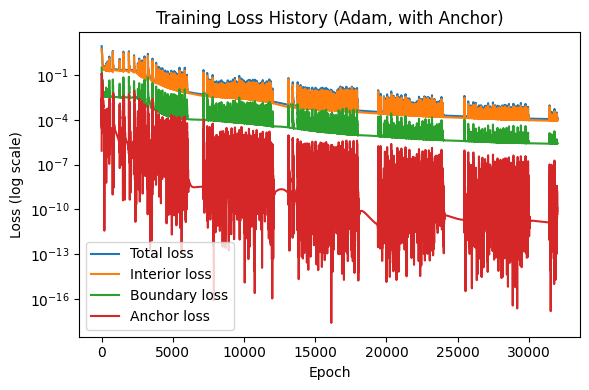

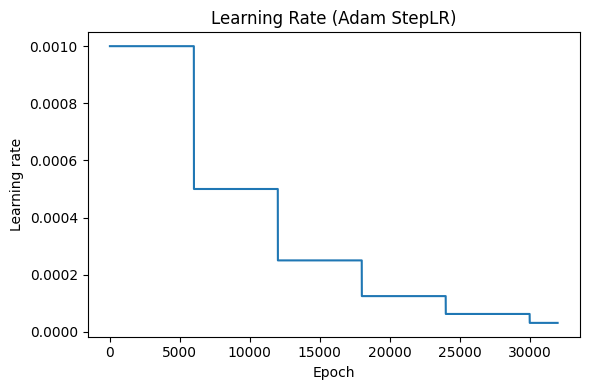

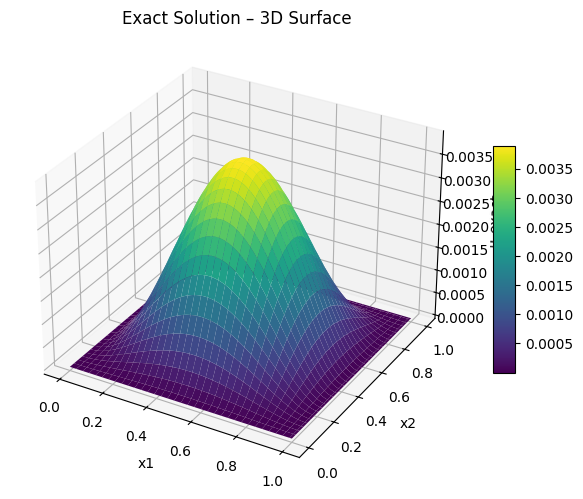

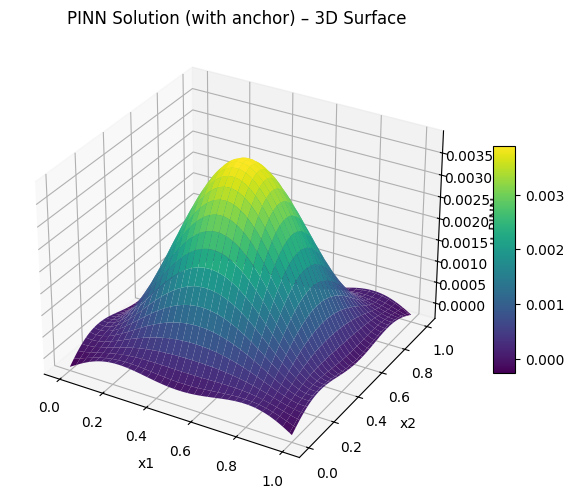

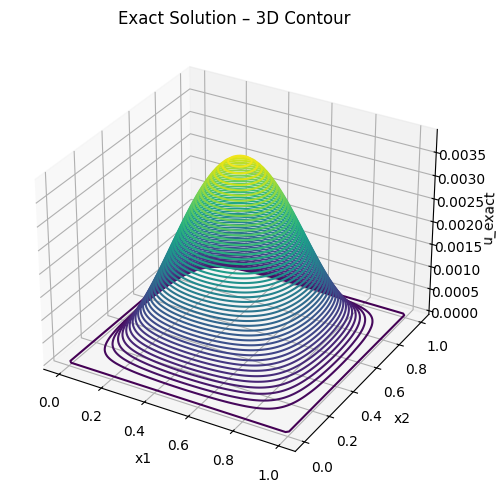

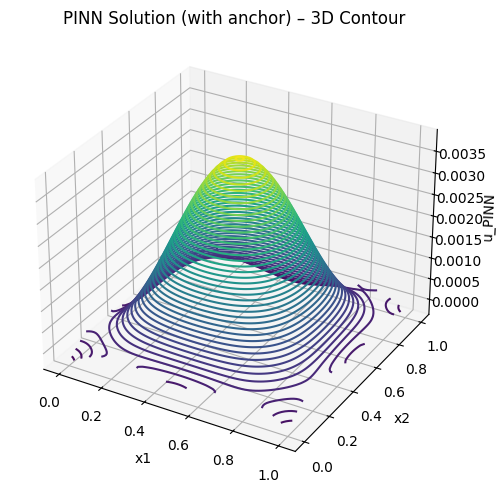

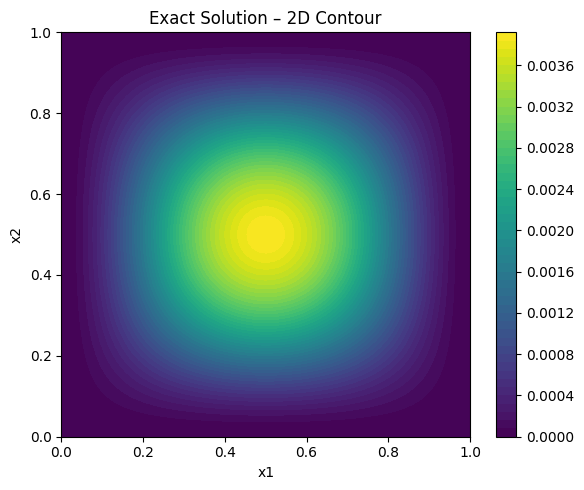

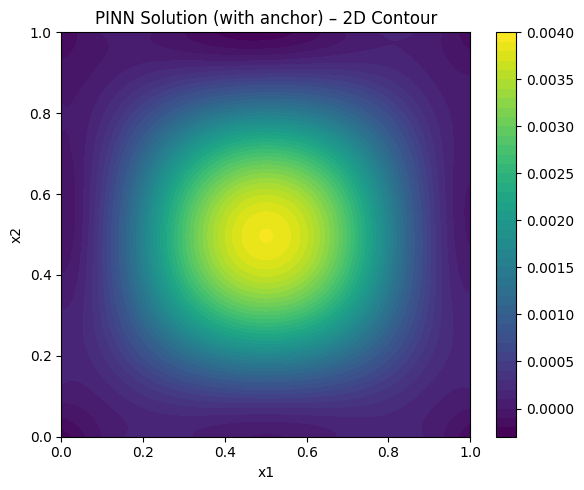


All results (plots + models) saved in: p4_example2_anchor_pinn


In [6]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =============================================================================
# HYPERPARAMETERS (TUNE THESE)
# =============================================================================
OUT_DIR          = "p4_example2_anchor_pinn"
SEED             = 42
TORCH_DTYPE      = torch.float64

# Collocation points
N_INT            = 10000          # interior points
N_BD_PER_EDGE    = 1000           # boundary points per edge (Nb = 4*N_BD_PER_EDGE)

# Loss weights
LAMBDA_INT       = 1.0
LAMBDA_BC        = 10.0
LAMBDA_ANCHOR    = 1.0           # weight for anchor constraint

# Anchor point (single interior point to fix constant)
ANCHOR_X         = 0.5
ANCHOR_Y         = 0.5

# Adam stage
MAX_EPOCHS_ADAM  = 32000
TARGET_LOSS      = 1e-5          # stop if total loss <= TARGET_LOSS
LOG_EVERY        = 500

INIT_LR          = 1e-3
STEP_SIZE_LR     = 6000
GAMMA_LR         = 0.5

# LBFGS refinement
USE_LBFGS        = True
LBFGS_MAX_ITER   = 1500
LBFGS_LR         = 1.0

# Network & evaluation grid
LAYERS           = [2, 96, 96, 96, 96, 1]
GRID_N           = 101
# =============================================================================

torch.set_default_dtype(TORCH_DTYPE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(SEED)
np.random.seed(SEED)
os.makedirs(OUT_DIR, exist_ok=True)

# =============================================================================
# Exact solution (for data generation, anchor, and evaluation ONLY)
#   Example 3.2: u(x1, x2) = x1^2 x2^2 (1 - x1)^2 (1 - x2)^2
# =============================================================================
def u_exact(X):
    x1 = X[:, 0:1]
    x2 = X[:, 1:2]
    return (x1**2) * (x2**2) * ((1.0 - x1)**2) * ((1.0 - x2)**2)

# =============================================================================
# PINN architecture
# =============================================================================
class BiharmonicPINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            lin = nn.Linear(layers[i], layers[i + 1])
            nn.init.xavier_uniform_(lin.weight)
            nn.init.zeros_(lin.bias)
            self.layers.append(lin)
        self.activation = nn.Tanh()

    def forward(self, x):
        for i, lin in enumerate(self.layers):
            x = lin(x)
            if i != len(self.layers) - 1:
                x = self.activation(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# =============================================================================
# Autograd helpers
# =============================================================================
def compute_grad_and_hessian(u, X):
    # First derivatives
    grad_u = torch.autograd.grad(
        u, X,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]
    u_x = grad_u[:, 0:1]
    u_y = grad_u[:, 1:2]

    # Second derivatives
    grad_u_x = torch.autograd.grad(
        u_x, X,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True
    )[0]
    grad_u_y = torch.autograd.grad(
        u_y, X,
        grad_outputs=torch.ones_like(u_y),
        create_graph=True
    )[0]

    u_xx = grad_u_x[:, 0:1]
    u_xy = grad_u_x[:, 1:2]
    u_yx = grad_u_y[:, 0:1]
    u_yy = grad_u_y[:, 1:2]
    u_xy_sym = 0.5 * (u_xy + u_yx)
    return grad_u, (u_xx, u_yy, u_xy_sym)

def biharmonic_u(u, X):
    # Δ²u = Δ(Δu)
    grad_u, (u_xx, u_yy, u_xy) = compute_grad_and_hessian(u, X)
    lap_u = u_xx + u_yy
    grad_lap, (lap_xx, lap_yy, lap_xy) = compute_grad_and_hessian(lap_u, X)
    return lap_xx + lap_yy

def normal_derivative(u, X, normals):
    grad_u, _ = compute_grad_and_hessian(u, X)
    return torch.sum(grad_u * normals, dim=1, keepdim=True)

def normal_derivative_laplacian(u, X, normals):
    grad_u, (u_xx, u_yy, u_xy) = compute_grad_and_hessian(u, X)
    lap_u = u_xx + u_yy
    grad_lap, _ = compute_grad_and_hessian(lap_u, X)
    return torch.sum(grad_lap * normals, dim=1, keepdim=True)

# =============================================================================
# Collocation sampling
# =============================================================================
def sample_interior(N_int):
    X_int = torch.rand(N_int, 2, device=device)
    X_int.requires_grad_(True)
    return X_int

def sample_boundary(N_bd_per_edge):
    y = torch.rand(N_bd_per_edge, 1, device=device)
    x = torch.rand(N_bd_per_edge, 1, device=device)

    # Left: x1=0, n=(-1,0)
    left   = torch.cat([torch.zeros_like(y), y], dim=1)
    n_left = torch.cat([-torch.ones_like(y), torch.zeros_like(y)], dim=1)

    # Right: x1=1, n=(1,0)
    right   = torch.cat([torch.ones_like(y), y], dim=1)
    n_right = torch.cat([torch.ones_like(y), torch.zeros_like(y)], dim=1)

    # Bottom: x2=0, n=(0,-1)
    bottom   = torch.cat([x, torch.zeros_like(x)], dim=1)
    n_bottom = torch.cat([torch.zeros_like(x), -torch.ones_like(x)], dim=1)

    # Top: x2=1, n=(0,1)
    top   = torch.cat([x, torch.ones_like(x)], dim=1)
    n_top = torch.cat([torch.zeros_like(x), torch.ones_like(x)], dim=1)

    X_bd = torch.cat([left, right, bottom, top], dim=0)
    normals = torch.cat([n_left, n_right, n_bottom, n_top], dim=0)

    X_bd.requires_grad_(True)
    return X_bd, normals

# =============================================================================
# PDE & BC data generation (from u_exact ONCE; then treated as given)
#   P4 (Cahn–Hilliard BC):
#     Δ²u = f in Ω
#     ∂u/∂n = g1 on ∂Ω
#     ∂Δu/∂n = g2 on ∂Ω
# =============================================================================
def f_source_autograd(X_in):
    X = X_in.clone().detach().to(device)
    X.requires_grad_(True)
    u_ex = u_exact(X)
    bih_ex = biharmonic_u(u_ex, X)
    return bih_ex.detach()

def boundary_data_autograd(X_bd_in, normals_bd):
    X_bd = X_bd_in.clone().detach().to(device)
    X_bd.requires_grad_(True)
    u_bd_ex = u_exact(X_bd)
    g1 = normal_derivative(u_bd_ex, X_bd, normals_bd)
    g2 = normal_derivative_laplacian(u_bd_ex, X_bd, normals_bd)
    return g1.detach(), g2.detach()

def exact_quantities_autograd(X_in):
    X = X_in.clone().detach().to(device)
    X.requires_grad_(True)
    u_ex = u_exact(X)
    grad_ex, (uxx_ex, uyy_ex, uxy_ex) = compute_grad_and_hessian(u_ex, X)
    return u_ex.detach(), grad_ex.detach(), uxx_ex.detach(), uyy_ex.detach(), uxy_ex.detach()

# =============================================================================
# Setup network & data
# =============================================================================
net = BiharmonicPINN(LAYERS).to(device)
print("\nNetwork:\n", net)
print("\nTotal parameters:", count_parameters(net))

# Collocation points
X_int = sample_interior(N_INT)
X_bd, normals_bd = sample_boundary(N_BD_PER_EDGE)

# PDE & BC data (computed once)
f_int  = f_source_autograd(X_int)
g1_bd, g2_bd = boundary_data_autograd(X_bd, normals_bd)

# Anchor point (single interior point)
X_anchor = torch.tensor([[ANCHOR_X, ANCHOR_Y]], device=device, dtype=TORCH_DTYPE)
u_anchor_exact = u_exact(X_anchor)  # known exact value at anchor

optimizer = torch.optim.Adam(net.parameters(), lr=INIT_LR)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=STEP_SIZE_LR, gamma=GAMMA_LR
)

loss_history_total = []
loss_history_int   = []
loss_history_bc    = []
loss_history_anchor = []
lr_history         = []

print("\n====================== Adam training with anchor (P4, Example 3.2) ======================\n")
start_time = time.time()

for epoch in range(1, MAX_EPOCHS_ADAM + 1):
    current_lr = optimizer.param_groups[0]["lr"]
    lr_history.append(current_lr)

    optimizer.zero_grad()

    # Interior loss: L_int = mean |Δ²uθ - f|²
    u_int = net(X_int)
    bih_int = biharmonic_u(u_int, X_int)
    res_int = bih_int - f_int
    L_int = torch.mean(res_int**2)

    # Boundary loss: mean [ |∂uθ/∂n - g1|² + |∂Δuθ/∂n - g2|² ]
    u_bd = net(X_bd)
    du_dn_pred   = normal_derivative(u_bd, X_bd, normals_bd)
    dlap_dn_pred = normal_derivative_laplacian(u_bd, X_bd, normals_bd)

    L_bc_u   = torch.mean((du_dn_pred   - g1_bd)**2)
    L_bc_lap = torch.mean((dlap_dn_pred - g2_bd)**2)
    L_bc = L_bc_u + L_bc_lap

    # Anchor loss: enforce uθ(x_anchor) ≈ u_exact(x_anchor)
    u_anchor_pred = net(X_anchor)
    L_anchor = torch.mean((u_anchor_pred - u_anchor_exact)**2)

    # Total loss
    loss = LAMBDA_INT * L_int + LAMBDA_BC * L_bc + LAMBDA_ANCHOR * L_anchor
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history_total.append(loss.item())
    loss_history_int.append(L_int.item())
    loss_history_bc.append(L_bc.item())
    loss_history_anchor.append(L_anchor.item())

    if epoch == 1 or epoch % LOG_EVERY == 0:
        print(
            f"Epoch {epoch:6d} | "
            f"LR: {current_lr:.3e} | "
            f"Total: {loss.item():.3e} | "
            f"Int: {L_int.item():.3e} | "
            f"BC: {L_bc.item():.3e} | "
            f"Anchor: {L_anchor.item():.3e}"
        )

    if loss.item() <= TARGET_LOSS:
        print(f"\nTarget loss {TARGET_LOSS:.1e} reached at epoch {epoch}. Stopping Adam.")
        break

# =============================================================================
# LBFGS refinement (same loss including anchor term)
# =============================================================================
if USE_LBFGS:
    print("\n====================== LBFGS refinement (with anchor) ======================\n")
    lbfgs = torch.optim.LBFGS(
        net.parameters(),
        lr=LBFGS_LR,
        max_iter=LBFGS_MAX_ITER,
        history_size=100,
        line_search_fn="strong_wolfe"
    )

    def closure():
        lbfgs.zero_grad()
        u_int = net(X_int)
        bih_int = biharmonic_u(u_int, X_int)
        res_int = bih_int - f_int
        L_int = torch.mean(res_int**2)

        u_bd = net(X_bd)
        du_dn_pred   = normal_derivative(u_bd, X_bd, normals_bd)
        dlap_dn_pred = normal_derivative_laplacian(u_bd, X_bd, normals_bd)

        L_bc_u   = torch.mean((du_dn_pred   - g1_bd)**2)
        L_bc_lap = torch.mean((dlap_dn_pred - g2_bd)**2)
        L_bc = L_bc_u + L_bc_lap

        u_anchor_pred = net(X_anchor)
        L_anchor = torch.mean((u_anchor_pred - u_anchor_exact)**2)

        loss_lbfgs = LAMBDA_INT * L_int + LAMBDA_BC * L_bc + LAMBDA_ANCHOR * L_anchor
        loss_lbfgs.backward()
        return loss_lbfgs

    final_loss = lbfgs.step(closure)
    print(f"LBFGS final loss: {final_loss.item():.3e}")

end_time = time.time()
training_time = end_time - start_time
print(f"\nTotal training time (Adam + LBFGS): {training_time:.2f} seconds.")

# =============================================================================
# Save model
# =============================================================================
state_path = os.path.join(OUT_DIR, "p4_example2_anchor_pinn_state_dict.pth")
full_path  = os.path.join(OUT_DIR, "p4_example2_anchor_pinn_full.pth")
torch.save(net.state_dict(), state_path)
torch.save(net, full_path)
print("\nSaved model state_dict to:", state_path)
print("Saved full model to:", full_path)

# =============================================================================
# Evaluation on dense grid (NO constant subtraction, anchor already fixes it)
# =============================================================================
print("\n====================== Evaluating on dense grid ======================\n")

xs = torch.linspace(0.0, 1.0, GRID_N, device=device)
ys = torch.linspace(0.0, 1.0, GRID_N, device=device)
Xg, Yg = torch.meshgrid(xs, ys, indexing="ij")
test_points = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=1)
test_points.requires_grad_(True)

u_pred = net(test_points)
grad_pred, (uxx_pred, uyy_pred, uxy_pred) = compute_grad_and_hessian(u_pred, test_points)
u_ex, grad_ex, uxx_ex, uyy_ex, uxy_ex = exact_quantities_autograd(test_points)

# L2, H1, H2 errors (raw, since anchor fixes constant)
du         = u_pred - u_ex
grad_diff  = grad_pred - grad_ex
u_diff_sq  = du**2
grad_diff_sq = grad_diff[:, 0:1]**2 + grad_diff[:, 1:2]**2

u_sq    = u_ex**2
grad_sq = grad_ex[:, 0:1]**2 + grad_ex[:, 1:2]**2

L2_error    = torch.sqrt(torch.mean(u_diff_sq)).item()
grad_L2_err = torch.sqrt(torch.mean(grad_diff_sq)).item()
L2_u        = torch.sqrt(torch.mean(u_sq)).item()
L2_grad_u   = torch.sqrt(torch.mean(grad_sq)).item()

energy_error = L2_error + grad_L2_err
L2_rel       = L2_error / L2_u
H1_rel       = energy_error / (L2_u + L2_grad_u)

# H2-like relative error
hess_diff_sq = (
    (uxx_pred - uxx_ex)**2 +
    (uyy_pred - uyy_ex)**2 +
    2.0 * (uxy_pred - uxy_ex)**2
)
hess_sq = uxx_ex**2 + uyy_ex**2 + 2.0 * (uxy_ex**2)
H2_rel = torch.sqrt(
    torch.mean(u_diff_sq + grad_diff_sq + hess_diff_sq) /
    torch.mean(u_sq + grad_sq + hess_sq)
).item()

print("---- Errors with anchor (no constant subtraction) ----")
print(f"L2 error               ≈ {L2_error:.3e}")
print(f"Energy error (H1)      ≈ {energy_error:.3e}")
print(f"L2 relative            ≈ {L2_rel:.3e}")
print(f"H1 relative            ≈ {H1_rel:.3e}")
print(f"H2 relative            ≈ {H2_rel:.3e}")

# =============================================================================
# Plots: loss, LR, 3D surfaces/contours, 2D contours
# =============================================================================
epochs_range = np.arange(1, len(loss_history_total) + 1)

# Loss history
plt.figure(figsize=(6, 4))
plt.semilogy(epochs_range, loss_history_total,   label="Total loss")
plt.semilogy(epochs_range, loss_history_int,     label="Interior loss")
plt.semilogy(epochs_range, loss_history_bc,      label="Boundary loss")
plt.semilogy(epochs_range, loss_history_anchor,  label="Anchor loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Training Loss History (Adam, with Anchor)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "loss_history.png"), dpi=300)
plt.show()

# LR history
plt.figure(figsize=(6, 4))
plt.plot(epochs_range, lr_history[:len(epochs_range)])
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Learning Rate (Adam StepLR)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "lr_history.png"), dpi=300)
plt.show()

# Prepare grids for plots
U_exact_grid = u_ex.detach().cpu().numpy().reshape(GRID_N, GRID_N)
U_pred_grid  = u_pred.detach().cpu().numpy().reshape(GRID_N, GRID_N)
X_plot       = Xg.detach().cpu().numpy()
Y_plot       = Yg.detach().cpu().numpy()

# 3D surfaces (coloured)
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
surf1 = ax.plot_surface(X_plot, Y_plot, U_exact_grid, cmap="viridis")
ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_zlabel("u_exact")
ax.set_title("Exact Solution – 3D Surface")
fig.colorbar(surf1, shrink=0.5, aspect=10)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "exact_3d_surface.png"), dpi=300)
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
surf2 = ax.plot_surface(X_plot, Y_plot, U_pred_grid, cmap="viridis")
ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_zlabel("u_PINN")
ax.set_title("PINN Solution (with anchor) – 3D Surface")
fig.colorbar(surf2, shrink=0.5, aspect=10)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pinn_3d_surface_anchor.png"), dpi=300)
plt.show()

# 3D contours (coloured)
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
ax.contour3D(X_plot, Y_plot, U_exact_grid, 50, cmap="viridis")
ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_zlabel("u_exact")
ax.set_title("Exact Solution – 3D Contour")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "exact_3d_contour.png"), dpi=300)
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
ax.contour3D(X_plot, Y_plot, U_pred_grid, 50, cmap="viridis")
ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_zlabel("u_PINN")
ax.set_title("PINN Solution (with anchor) – 3D Contour")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pinn_3d_contour_anchor.png"), dpi=300)
plt.show()

# 2D contours
plt.figure(figsize=(6, 5))
cf1 = plt.contourf(X_plot, Y_plot, U_exact_grid, levels=50)
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("Exact Solution – 2D Contour")
plt.colorbar(cf1)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "exact_2d_contour.png"), dpi=300)
plt.show()

plt.figure(figsize=(6, 5))
cf2 = plt.contourf(X_plot, Y_plot, U_pred_grid, levels=50)
plt.xlabel("x1"); plt.ylabel("x2")
plt.title("PINN Solution (with anchor) – 2D Contour")
plt.colorbar(cf2)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pinn_2d_contour_anchor.png"), dpi=300)
plt.show()

print("\nAll results (plots + models) saved in:", OUT_DIR)
